In [228]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [229]:
data=pd.read_csv('/kaggle/input/productdemandforecasting/Historical Product Demand.csv')
prod=pd.unique(data['Product_Code']).tolist()
cate=pd.unique(data['Product_Category']).tolist()
ware=pd.unique(data['Warehouse']).tolist()

In [230]:
data.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [231]:
data['Order_Demand'] = data['Order_Demand'].str.replace('(',"")
data['Order_Demand'] = data['Order_Demand'].str.replace(')',"")
data['Order_Demand'] = data['Order_Demand'].astype('int64')

In [232]:
print(len(prod),len(cate),len(ware))
data.head()

2160 33 4


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [233]:
food=['Dairy_products','baked_products','sugar_baked','eggs','meat','poultry','fish','flour','seafood','legumes ','cooked_food','cooked_vegetables','cooked_meat','leftovers','other_fruits','other_vegetable','Citrus','Stone_fruit','Tropical','peas','berries','melons','green_vegetables','Cruciferous','acidic_fruits','Marrow','root','allium','Soy Products','fresh_drinks','processed_food','desserts','bevarages']
food.sort()
for i in range(data.shape[1]):
    data=data.replace(to_replace=cate[i],value=food[i])

In [235]:
order=[]
for i in range(data.shape[0]):
    if data.iloc[i,0]=='Product_0979' and data.iloc[i,1]=='Whse_J' and data.iloc[i,2]=='Citrus':
        order.append([data.iloc[i,3],data.iloc[i,4]])
df=pd.DataFrame(data=order,columns=['Date','Order_Demand'])
df['Date']=pd.DatetimeIndex(df['Date'])
final=df.pivot_table(index='Date',aggfunc=sum)

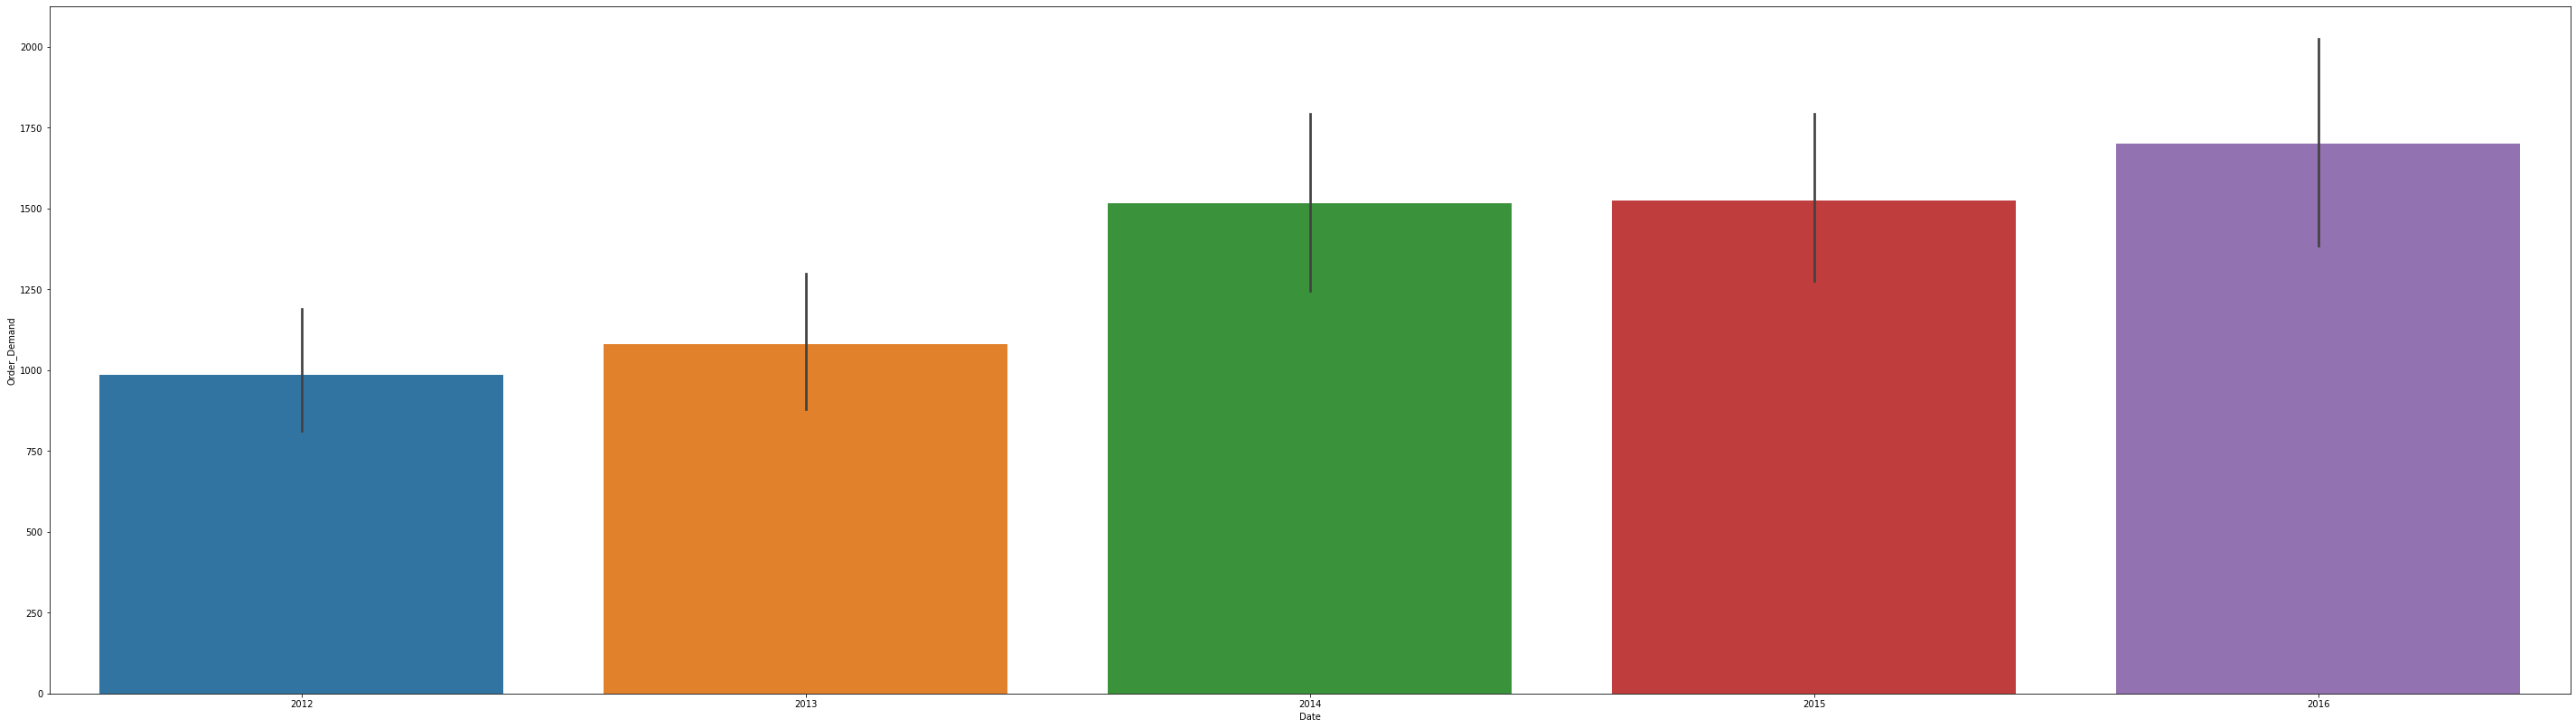

In [158]:
rcParams['figure.figsize'] = 50,14
sns.barplot(x=pd.DatetimeIndex(df['Date']).year, y=df['Order_Demand'])

In [ ]:
#np.random.uniform(low=1.3, high=9.2, size=(33,))

In [ ]:
import seaborn as sns
rcParams['figure.figsize'] = 5,3
sns.distplot(df['Order_Demand'], fit=norm)
#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['Order_Demand'], plot=plt)
plt.show()

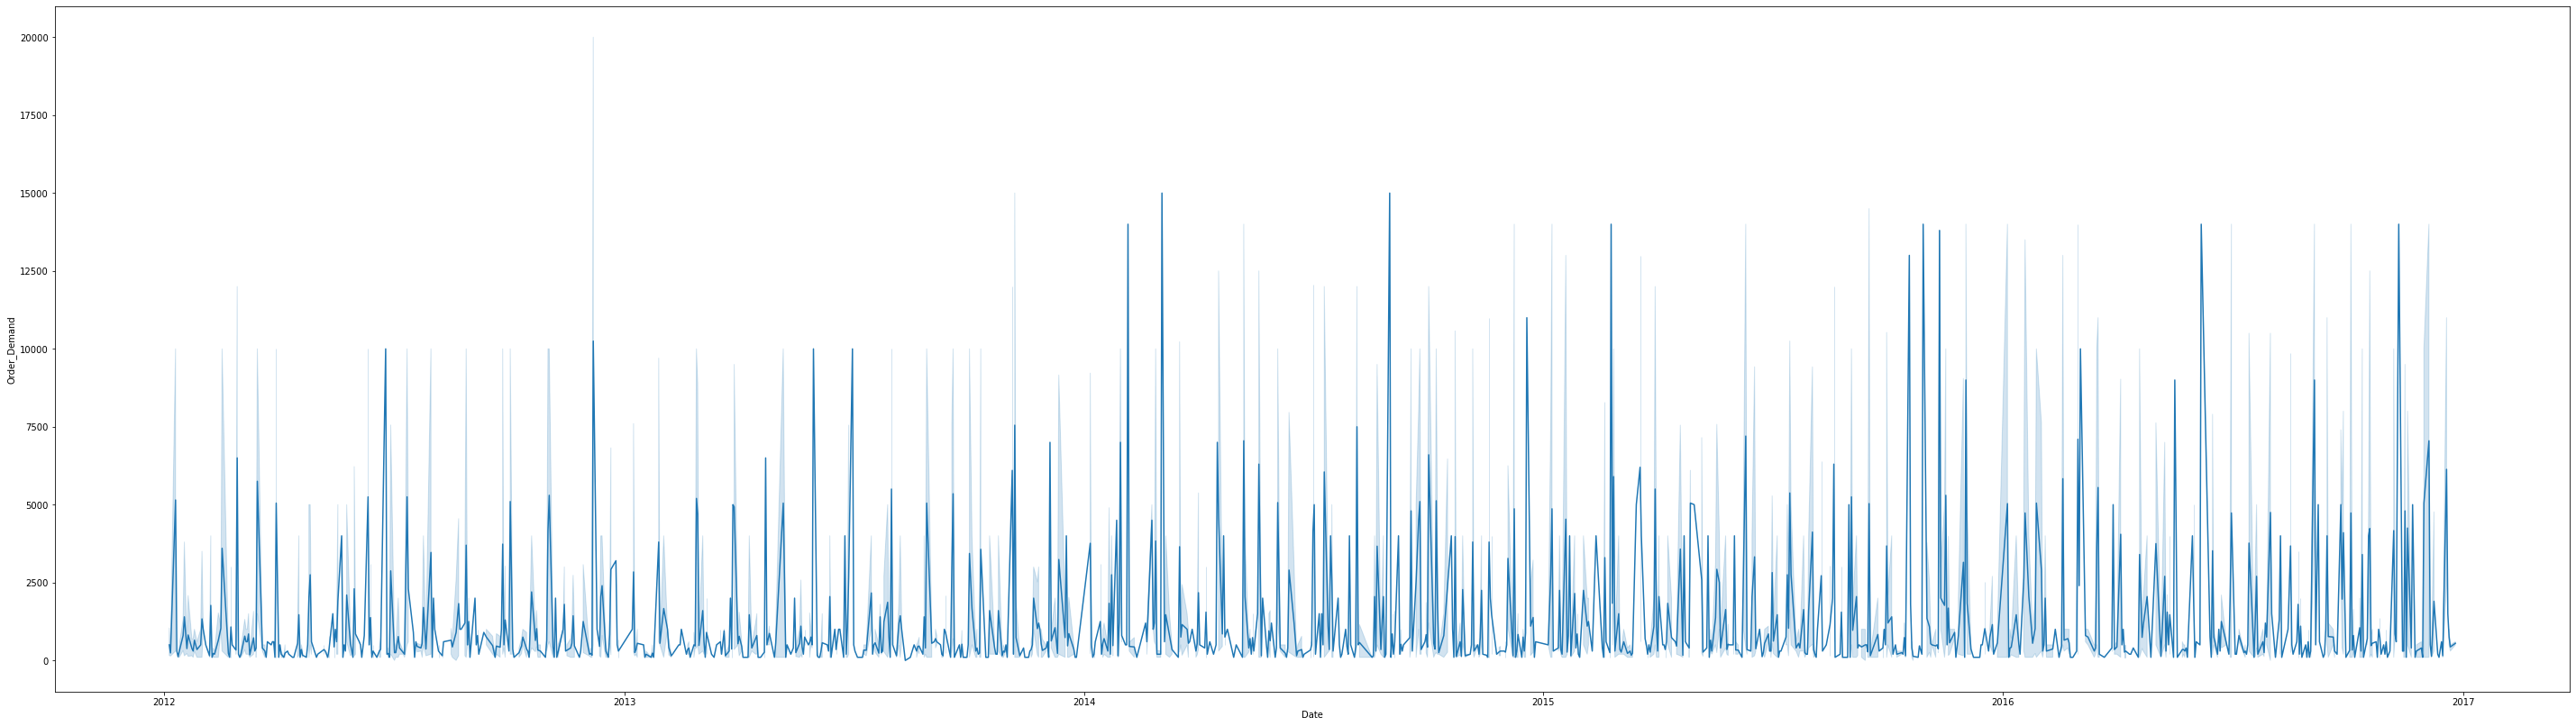

In [76]:
sns.lineplot(x=df['Date'], y=df['Order_Demand'])

In [ ]:
y =final.resample('M').sum()
y.index.freq = "M"
final= pd.DataFrame(y["Order_Demand"]) 
final.head()

In [77]:
! pip install pmdarima

     |████████████████████████████████| 1.5 MB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 49.0 MB/s eta 0:00:01
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.20
    Uninstalling Cython-0.29.20:
      Successfully uninstalled Cython-0.29.20


In [267]:
from pmdarima import auto_arima
model= auto_arima(final['Order_Demand'], start_p=1, start_q=1,
                          max_p=5, max_q=5, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

model.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=1065.038, BIC=1074.394, Time=0.198 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=1076.676, BIC=1080.418, Time=0.013 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=1067.271, BIC=1074.756, Time=0.099 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=1071.447, BIC=1078.932, Time=0.101 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=1077.319, BIC=1079.190, Time=0.019 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=1080.674, BIC=1088.159, Time=0.066 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=1064.561, BIC=1075.788, Time=0.301 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=1065.679, BIC=1075.035, Time=0.189 seconds
Fit ARIMA(1,0,1)x(2,1,1,12) [intercept=True]; AIC=1066.493, BIC=1079.591, Time=0.839 seconds
Fit ARIMA(1,0,1)x(1,1,2,12) [intercept=True]; AIC=1066.523, BIC=1079.622, Time=0.776 seconds
Fit ARIMA(1,0,1)x(0,1,2,12

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   60
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                -526.276
Date:                             Mon, 13 Jul 2020   AIC                           1064.553
Time:                                     07:06:30   BIC                           1075.780
Sample:                                          0   HQIC                          1068.795
                                              - 60                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2793.9047   6898.642      0.405      0.685   -1.07e+04    1.63e+04
ar.L1          0.8395      0.335      2.506      0.012       0.183       1.496
ma.L1         -0.5903      0.467     -1.264      0.206      -1.505       0.325
ar.S.L12      -0.8283      0.296     -2.797      0.005      -1.409      -0.248
ar.S.L24      -0.3049      0.316     -0.964      0.335      -0.925       0.315
sigma2      3.053e+08      0.096   3.18e+09      0.000    3.05e+08    3.05e+08
===================================================================================
Ljung-Box (Q):                       28.26   Jarque-Bera (JB):                 9.10
Prob(Q):                              0.92   Prob(JB):                         0.01
Heteroskedasticity (H):               1.61   Skew:                             0.76
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.52e+25. Standard errors may be unstable.
"""

In [251]:
dtrain=final['Order_Demand'].iloc[:45]
dtest=final['Order_Demand'].iloc[45:]

In [268]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod= SARIMAX(dtrain,order=(2,0,2),seasonal_order=(2,1,0,12))
result=mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Order_Demand   No. Observations:                   45
Model:             SARIMAX(2, 0, 2)x(2, 1, [], 12)   Log Likelihood                -359.862
Date:                             Mon, 13 Jul 2020   AIC                            733.723
Time:                                     07:06:46   BIC                            744.199
Sample:                                 01-31-2012   HQIC                           737.248
                                      - 09-30-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1092      0.871      0.125      0.900      -1.597       1.816
ar.L2          0.8756      0.877      0.999      0.318      -0.843       2.594
ma.L1          0.0029      0.739      0.004      0.997      -1.445       1.451
ma.L2         -0.9136      0.742     -1.231      0.218      -2.369       0.541
ar.S.L12      -0.5345      0.540     -0.990      0.322      -1.593       0.524
ar.S.L24      -0.0758      0.574     -0.132      0.895      -1.201       1.049
sigma2      2.697e+08   9.78e-09   2.76e+16      0.000     2.7e+08     2.7e+08
===================================================================================
Ljung-Box (Q):                       18.45   Jarque-Bera (JB):                 5.23
Prob(Q):                              0.97   Prob(JB):                         0.07
Heteroskedasticity (H):               2.16   Skew:                             0.60
Prob(H) (two-sided):                  0.22   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.25e+32. Standard errors may be unstable.
"""

In [269]:
predictions = result.predict(start=len(dtrain), end=len(dtrain)+len(dtest)-1, dynamic=False, typ='levels').rename('predicted')

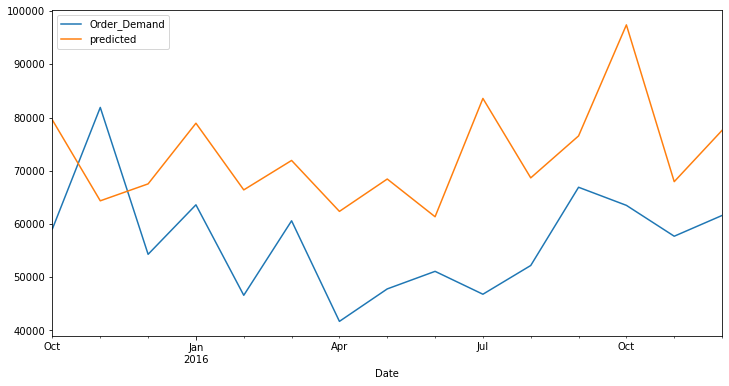

In [270]:
ax=dtest.plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)

In [262]:
from sklearn.metrics import mean_squared_error

error = np.sqrt(mean_squared_error(dtest, predictions))
print(f'SARIMA(2,0,2)(2,1,0,12) RMSE Error: {error:11.10}')
print('Std of Test data:                  ', final['Order_Demand'].std())

SARIMA(0,1,3)(1,0,1,12) RMSE Error:  9870.01245
Std of Test data:                   13353.309647090244


In [271]:
model = SARIMAX(final['Order_Demand'],order=(2,0,2),seasonal_order=(2,1,0,12))
results = model.fit()
fcast = results.predict(len(final['Order_Demand']),len(final['Order_Demand'])+3,typ='levels').rename('next_3_months_predicted')

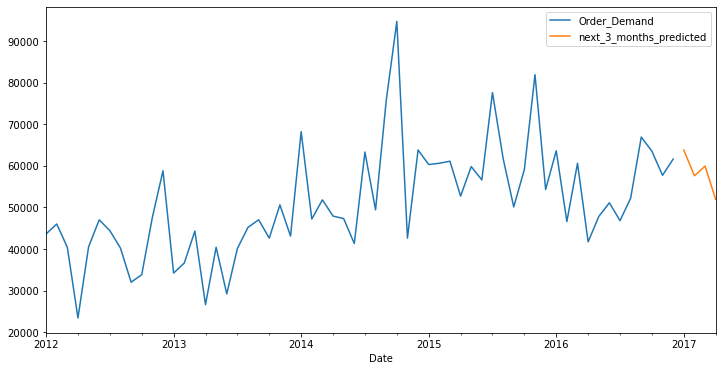

In [272]:
ax =final['Order_Demand'].plot(legend=True,figsize=(12,6))
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [266]:
'''temperature=[7, 2, 6, 2, 6, 7, 3, 1, 6, 6, 4, 3, 7, 6, 4, 4, 5, 7, 3, 7, 5, 7,5, 2, 5, 4, 1, 3, 3, 3, 4, 2, 3]
temp=pd.DataFrame(data=data['Product_Category'],columns='Temperature')
for i in range(data.shape[1]):
    temp=temp.replace(to_replace=food[i],value=temperature[i])
data=data.join(temp)'''

"temp=pd.DataFrame(data=data['Product_Category'],columns='Temperature')\nfor i in range(data.shape[1]):\n    temp=temp.replace(to_replace=food[i],value=temperature[i])\ndata=data.join(temp)"

In [ ]:
#output is the graph in grey area By plotting the x axis(date) against y axis(demand) we can get the predicted demand